# Análise da Perda de Funcionário

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import glob
import os
from typing import Dict, List, Tuple, Any
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(style='darkgrid')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)

## Baixando os Dados Utilizando a API do Kaggle

In [2]:
# Instalando a API do Kaggle
# !pip install kaggle --upgrade

In [3]:
!kaggle datasets download -d pavansubhasht/ibm-hr-analytics-attrition-dataset

'kaggle' nao � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


Lidando com o dado de resultado da API do Kaggle. Podemos observar, primeiramente, que o arquivo vem zipado, portanto, teremos que descompactá-lo para depois trabalhar com ele

In [4]:
# Importando todos os arquivos zip do diretório
zip_files = glob.glob('*.zip')
zip_files

['ibm-hr-analytics-attrition-dataset.zip']

In [5]:
try:
    for file in zip_files:
        with ZipFile(file, 'r') as zip_file:
            zip_file.extractall()
            n = 0
            for file in zip_file.namelist():
                if file.endswith('.csv'):
                    n += 1
                    os.rename(file, f'attrition_data{n}.csv')                
            zip_file.close()
except:
    pass

In [6]:
z = ZipFile('ibm-hr-analytics-attrition-dataset.zip')
z.namelist()

['WA_Fn-UseC_-HR-Employee-Attrition.csv']

## Análise Exploratória de Dados

In [7]:
data = pd.read_csv("attrition_data1.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Das informações acima, podemos observar que a base de dados não possui colunas com valores nulos. Portanto, seguimos investigando alguns atributos

In [8]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Temos que a variável alvo "Attrition" está descrita de maneira categórica, algo que podemos modificar para que esta possa ser melhor abordada no futuro. Para isso, façamos a seguinte substituição: No -> 0, Yes -> 1

In [9]:
data_copy = deepcopy(data)
data_copy.loc[data_copy["Attrition"] == "Yes", "Attrition"] = 1
data_copy.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [10]:
data.loc[data["Attrition"]=="Yes", "Attrition"] = 1
data.loc[data["Attrition"] == "No", "Attrition"] = 0
data[["Attrition"]] = data[["Attrition"]].astype("int")

Isso poderá nos auxiliar a construir relações quantitativas melhores entre a variável alvo e as variáveis dependentes. Como podemos ver, há também um alto número de colunas na base de dados. Talvez um ponto interessante para que possamos reduzir essa quantidade de colunas é realizando uma feature importance

In [11]:
# Separando a variável alvo das variáveis dependentes
    # Variáveis dependentes
x_feature_importance = data.drop(columns="Attrition").select_dtypes(include=np.number)

x_features_names = x_feature_importance.columns

y_feature_importance = data[["Attrition"]]

In [12]:
# Dividindo a base de dados
x_train, x_test, y_train, y_test = train_test_split(x_feature_importance,
                                                    y_feature_importance,
                                                   test_size=0.3,
                                                   random_state=13)

In [13]:
x_train.to_numpy().shape, y_train.to_numpy().reshape(1,-1).shape

((1029, 26), (1, 1029))

In [14]:
# usar o lightgbm
forest_importance = RandomForestClassifier(random_state=13)
forest_importance.fit(x_train, y_train.values.ravel())
importances = forest_importance.feature_importances_


importances = permutation_importance(forest_importance,
                               x_test, y_test, n_repeats=50, random_state=13, n_jobs=2
                               )

In [15]:
importance_to_plot = list(importances.importances_mean)
importance_to_plot.sort()
features_importance = pd.Series(importance_to_plot, index=x_features_names)

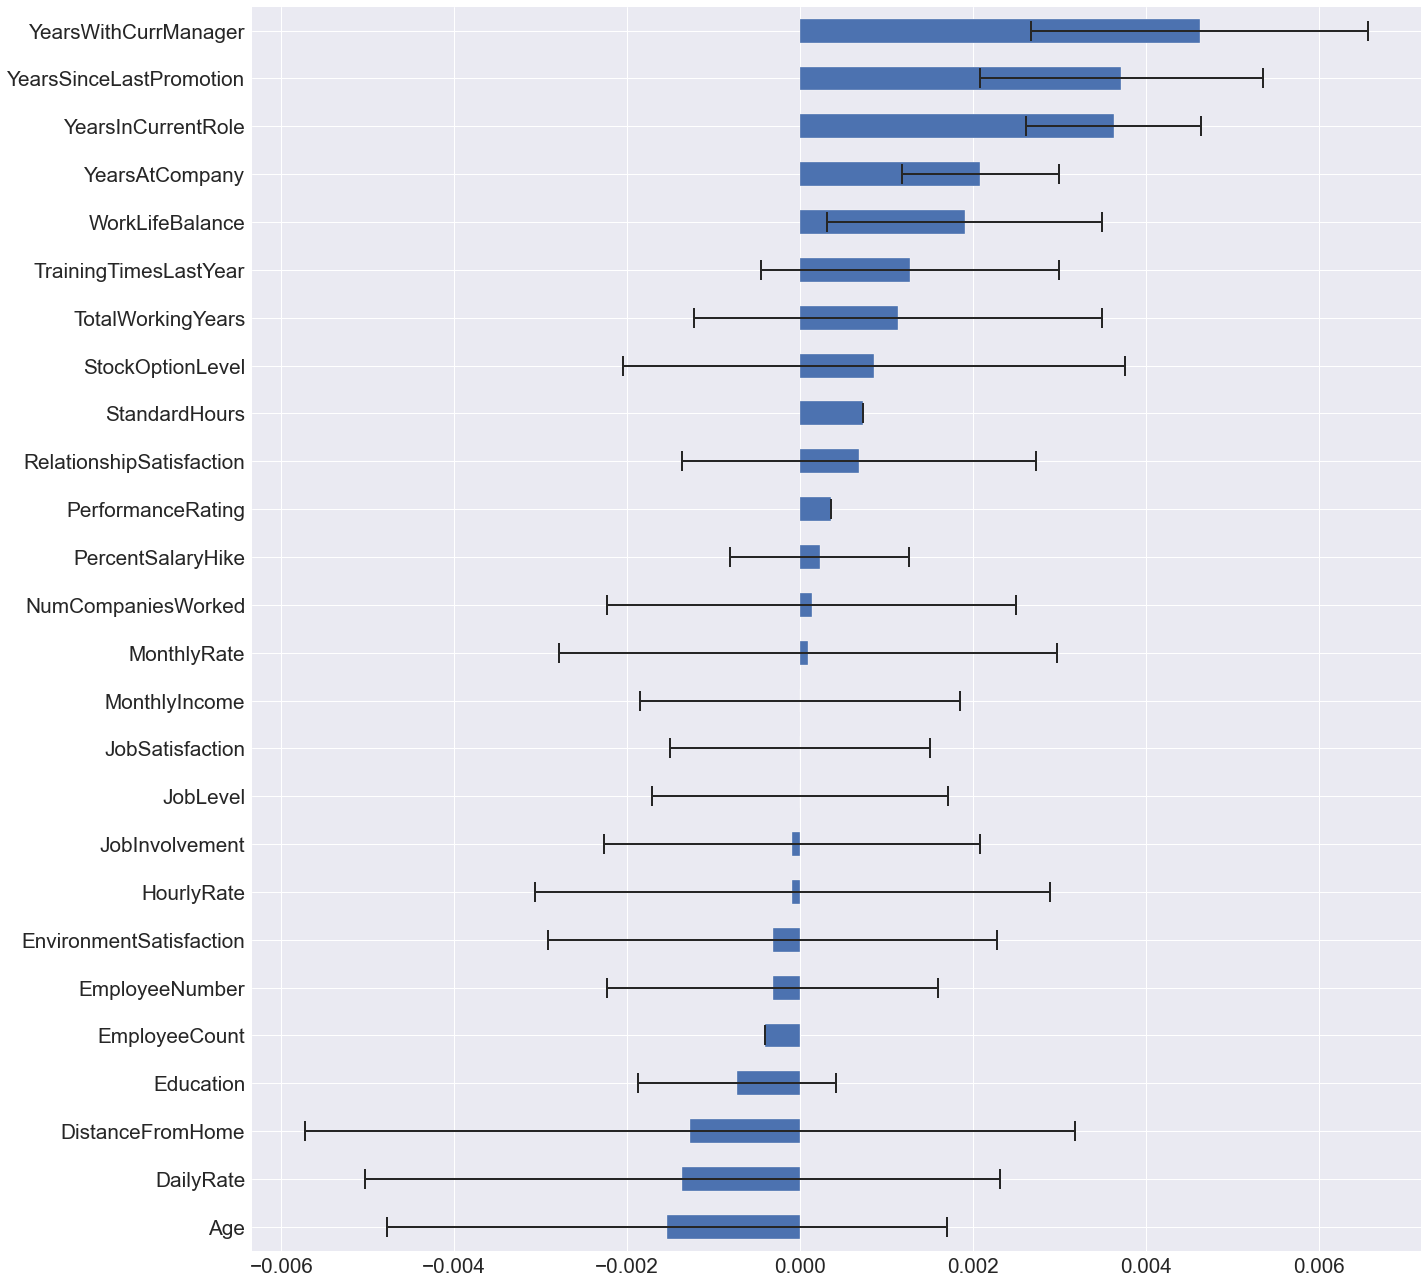

In [16]:
fig, ax = plt.subplots(figsize=(20,18))
features_importance.plot.barh(xerr=importances.importances_std, ax=ax,
                             error_kw={'elinewidth': 2, 'capsize': 10, 'capthick': 2})
ax.tick_params(labelsize='xx-large')
fig.tight_layout()
# ax.set_xticks(importances.importances_mean)
plt.show()

Esta análise, apesar de tomar apenas dados numéricos, excluindo os categóricos, possibilita que entendemos quais categóricos possivelmente podem ser utilizados para melhorar a análise.

Mas antes de partimos para a análise de dados categóricos, faremos algumas inferências a partir da importância dos atributos acima. 

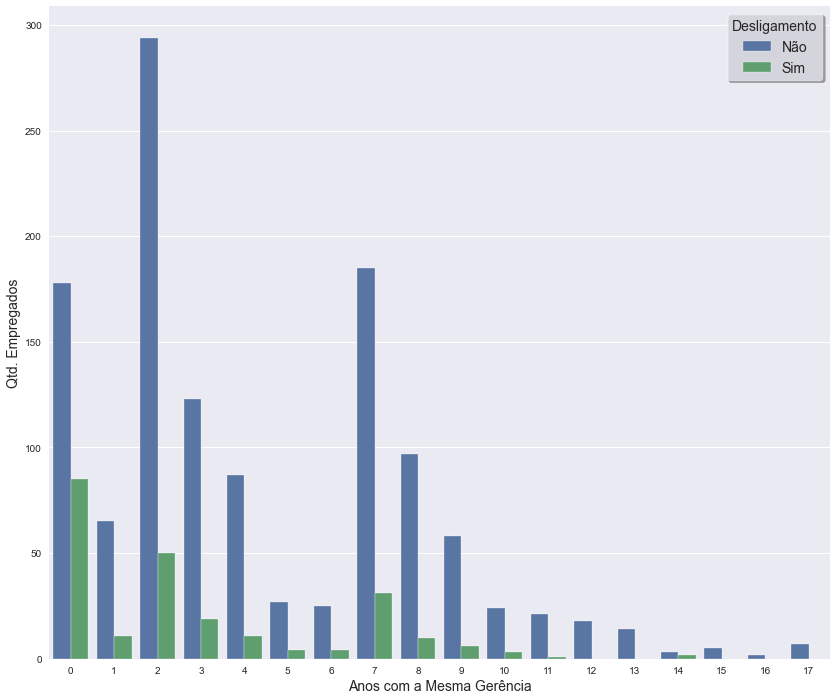

In [152]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsWithCurrManager, hue=data.Attrition)
plt.xlabel('Anos com a Mesma Gerência', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

No gráfico de barras acima, é construída a relação entre a variável número de anos com o atual gerente e a variável alvo.  Podemos verificar melhor essa relação plotando a densidade de funcionários perdidos pelo número de anos com o atual gerente.

In [21]:
def binary_cumulative(data_frame: pd.DataFrame, variavel_explicativa: str,
 variavel_alvo: str, sorted: bool = False) -> Dict[Any, List]:
  
  """
  Função que calcula, para uma variável alvo binária, a quantidade de ocorrências de \n
  cada valor da variável alvo, em cada valor da variável explicativa.
  """

  # ------------------------------------------------------------ #
  
  # Inicializando o dicionário que armazenará os resultados
  dict_result = {}

  # ------------------------------------------------------------ #

  # Armazenando em um array os valores únicos da variavel explicativa
  if sorted:
    data_feature_unique_values = np.sort(data_frame[variavel_explicativa].unique())
  else:
    data_feature_unique_values = data_frame[variavel_explicativa].unique()

  # ------------------------------------------------------------ #

  # Armazenando os valores únicos da variavel alvo
  binary_target = np.sort(data_frame[variavel_alvo].unique())

    # Criando uma tupla para abrigar os valores da variável alvo
  binary_values_target = (binary_target[0], binary_target[1])

  # ------------------------------------------------------------ #


  # Loop para calcular a ocorrência dos valores binários da variável alvo, em cada valor da variável explicativa

  for i in data_feature_unique_values:
    dict_result[i] = [data_frame.loc[(data_frame[variavel_alvo]==binary_values_target[0]) & (data_frame[variavel_explicativa]==i)].__len__(),
                           data_frame.loc[(data_frame[variavel_alvo]==binary_values_target[1]) & (data_frame[variavel_explicativa]==i)].__len__()] 

  # ------------------------------------------------------------ #

  # Retornando um dicionário com os resultados {variável explicativa: (ocorrencias da variavel alvo 1, ocorrencias da variavel alvo 2)}
  return dict_result 

In [94]:
def to_plot_cumulative(data_frame: pd.DataFrame, variavel_explicativa: str, 
  variavel_alvo: str, index: int) -> Tuple:
  """
  Função que gera dados prontos para plot, considerando o agregado dos valores binários\n
  para cada valor da variável explicativa.
  """

  # ------------------------------------------------------------ #

  # Iniciando as listas que serão utilizadas para armazenar os dados
  list_key = []
  list_values = []
  list_proportion = []
  # ------------------------------------------------------------ #

  # Gerando o dicionário com os resultados da função binary_cumulative
  dict_result = binary_cumulative(data_frame, variavel_explicativa, variavel_alvo)

  # ------------------------------------------------------------ #

  # Loop para desempacotar o dicionário de resultados
  for i, j in zip(dict_result.keys(), dict_result.values()):
    list_key.append(i)
    list_values.append(j[index])
    list_proportion.append(j[index]/i)

  # ------------------------------------------------------------ #

  # Retornando uma tupla com os dados prontos para plot
  return list_key, list_values

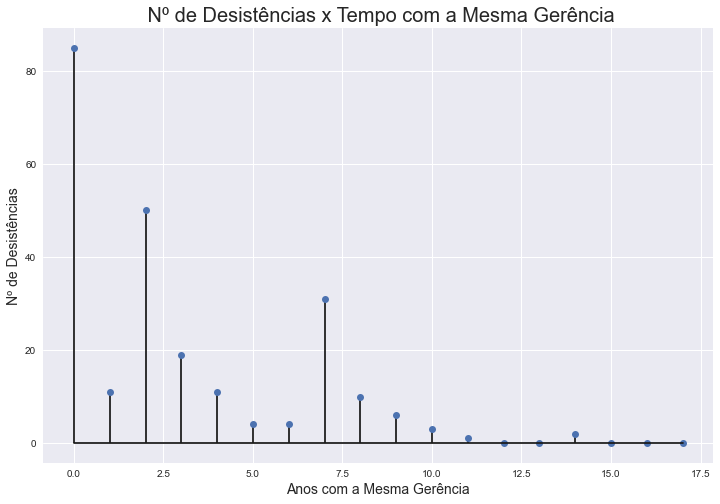

In [124]:
x, y  = to_plot_cumulative(data, "YearsWithCurrManager", "Attrition", 1)
plt.stem(x, y, markerfmt='bo', basefmt='k-', linefmt='k-')
plt.title(" Nº de Desistências x Tempo com a Mesma Gerência", fontsize=20)
plt.xlabel("Anos com a Mesma Gerência", fontsize=14)
plt.ylabel("Nº de Desistências", fontsize=14)
plt.show()

O gráfico acima pode indicar que a troca de gerência pode ocasionar em uma tendência de perda de funcionários e até uma predileção dos funcionários por ambientes de maior estabilidade. Pois tenha vista que a troca de uma gerência pode impactar muito no dia-a-dia dos funcionários de uma empresa. Logo, se uma empresa troca de gerência muitas vezes, pode se esperar que o ambiente de trabalho seja mais instável, com mais mudanças de estruturação.

Podemos investigar outros atributos que podem indicar informar um pouco mais sobre essa tendência. Por exmeplo, podemos verificar como os anos na empresa são correlacionados com a quantidade de funcionários perdidos.

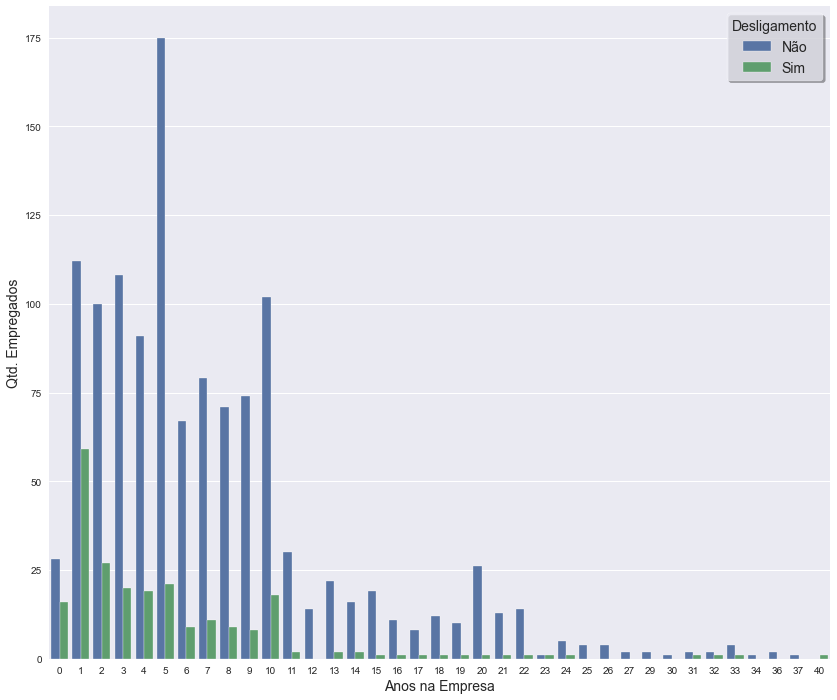

In [151]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsAtCompany, hue=data.Attrition)
plt.xlabel('Anos na Empresa', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

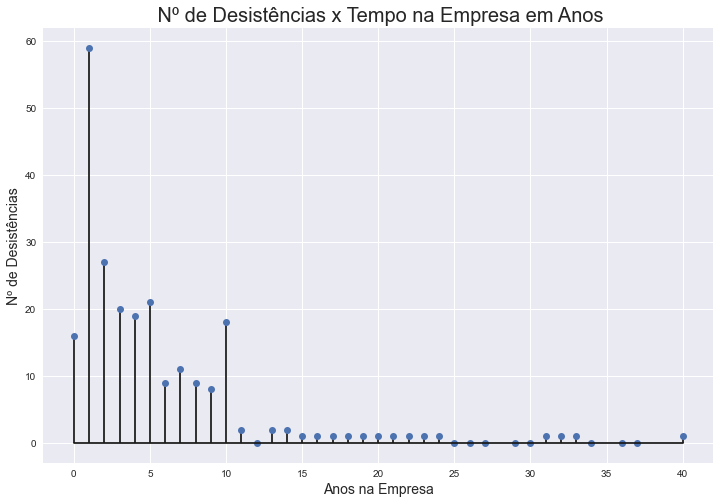

In [125]:
x, y  = to_plot_cumulative(data, "YearsAtCompany", "Attrition", 1)
plt.stem(x, y, markerfmt='bo', basefmt='k-', linefmt='k-')
plt.title(" Nº de Desistências x Tempo na Empresa em Anos", fontsize=20)
plt.xlabel("Anos na Empresa", fontsize=14)
plt.ylabel("Nº de Desistências", fontsize=14)
plt.show()

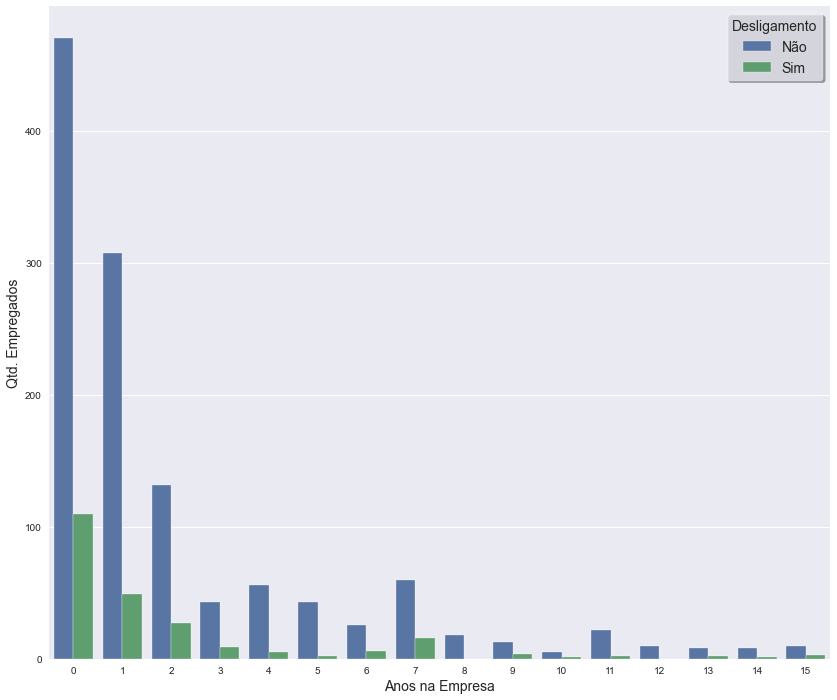

In [156]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsSinceLastPromotion, hue=data.Attrition)
plt.xlabel('Anos na Empresa', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

Outra variável que podemos observar é a de anos desde a última promoção.

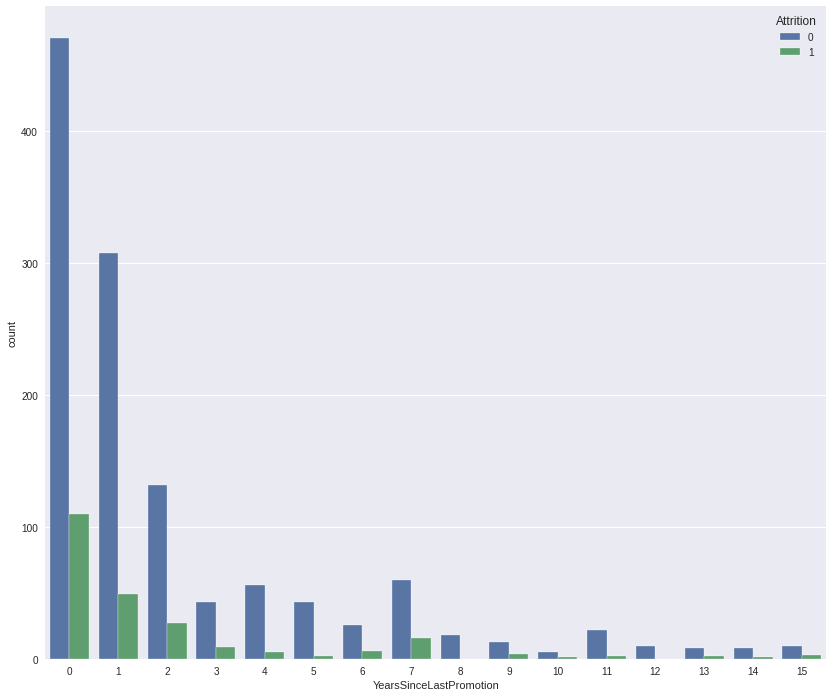

In [42]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsSinceLastPromotion, hue=data.Attrition)
plt.show()

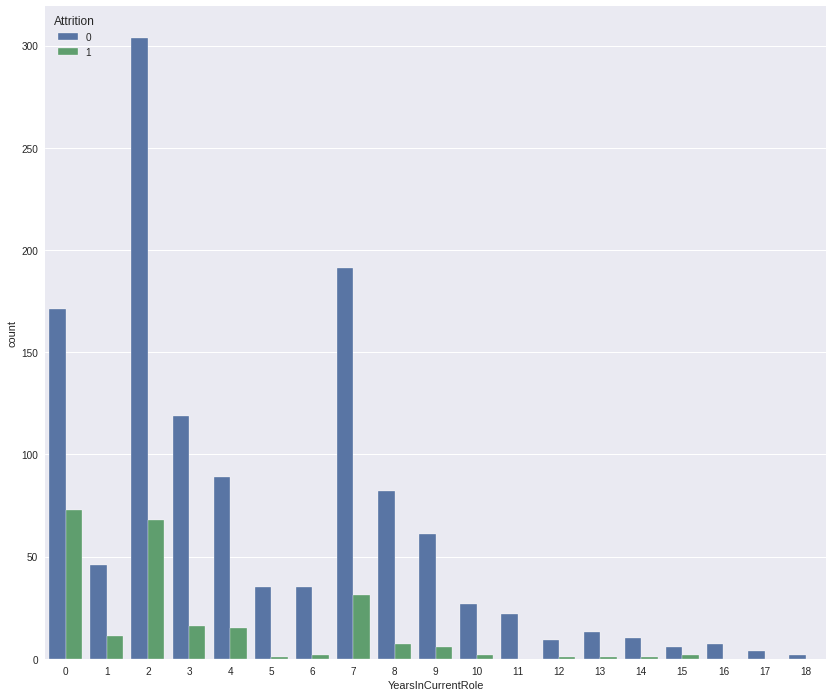

In [43]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsInCurrentRole, hue=data.Attrition)
plt.show()